# Machine Learning Model 
---

In [135]:
ticker = 'TSLA'

# Colors
lightblue = '#4ac2fb'
pinkyred = '#ff4e97'
black='#333333'

### Import Libraries 

In [7]:
import os
import warnings

import pandas as pd
import seaborn as sns
import numpy as np

from importlib import reload
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.rcParams['figure.dpi'] = 227

warnings.filterwarnings('ignore')

### Import ARIMA, SARIMA Libraries

In [35]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, accuracy_score
from pandas.plotting import autocorrelation_plot

### Import Tensorflow Keras Libraries 

In [3]:
import tensorflow.keras as keras

from tensorflow.python.keras.optimizer_v2 import rmsprop
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, TimeDistributed, LSTM, Dense, Bidirectional, Dropout, ConvLSTM2D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Convolution1D, BatchNormalization, LeakyReLU
from tensorflow.keras.utils import plot_model


from bayes_opt import BayesianOptimization
from functools import partial 

In [4]:
np.random.seed(66)

### Import Data

In [8]:
files = os.listdir('data/stocks')
stocks = {}
for file in files:
    if file.split('.')[1] == 'csv':
        name = file.split('.')[0]
        stocks[name] = pd.read_csv('data/stocks/'+file, index_col='Date')
        stocks[name].index = pd.to_datetime(stocks[name].index)

In [27]:
print(files)

['amzn.csv', 'msft.csv', 'fb.csv', 'tsla.csv', 'googl.csv', 'goog.csv', '.ipynb_checkpoints', 'aapl.csv']


---
# Baseline Model
- benchmark for comparing future more complex models
---

In [73]:
def baseline_model(stock):
    
    Binary = lambda data: [1 if x > 0 else 0 for x in data] 
    
    pred = np.random.randint(0,2,len(stock))
    accuracy = accuracy_score(Binary(stock), pred)
    
    return accuracy

In [75]:
baseline_accuracy = baseline_model(stocks[ticker.lower()].Return)
print('Baseline Model Accuracy: {:.1f}%'.format(baseline_accuracy*100))

Baseline Model Accuracy: 49.9%


### Accuracy Distribution

In [76]:
baseline_preds = []
for i in range(1000):
    baseline_preds.append(baseline_model(stocks[ticker.lower()].Return))

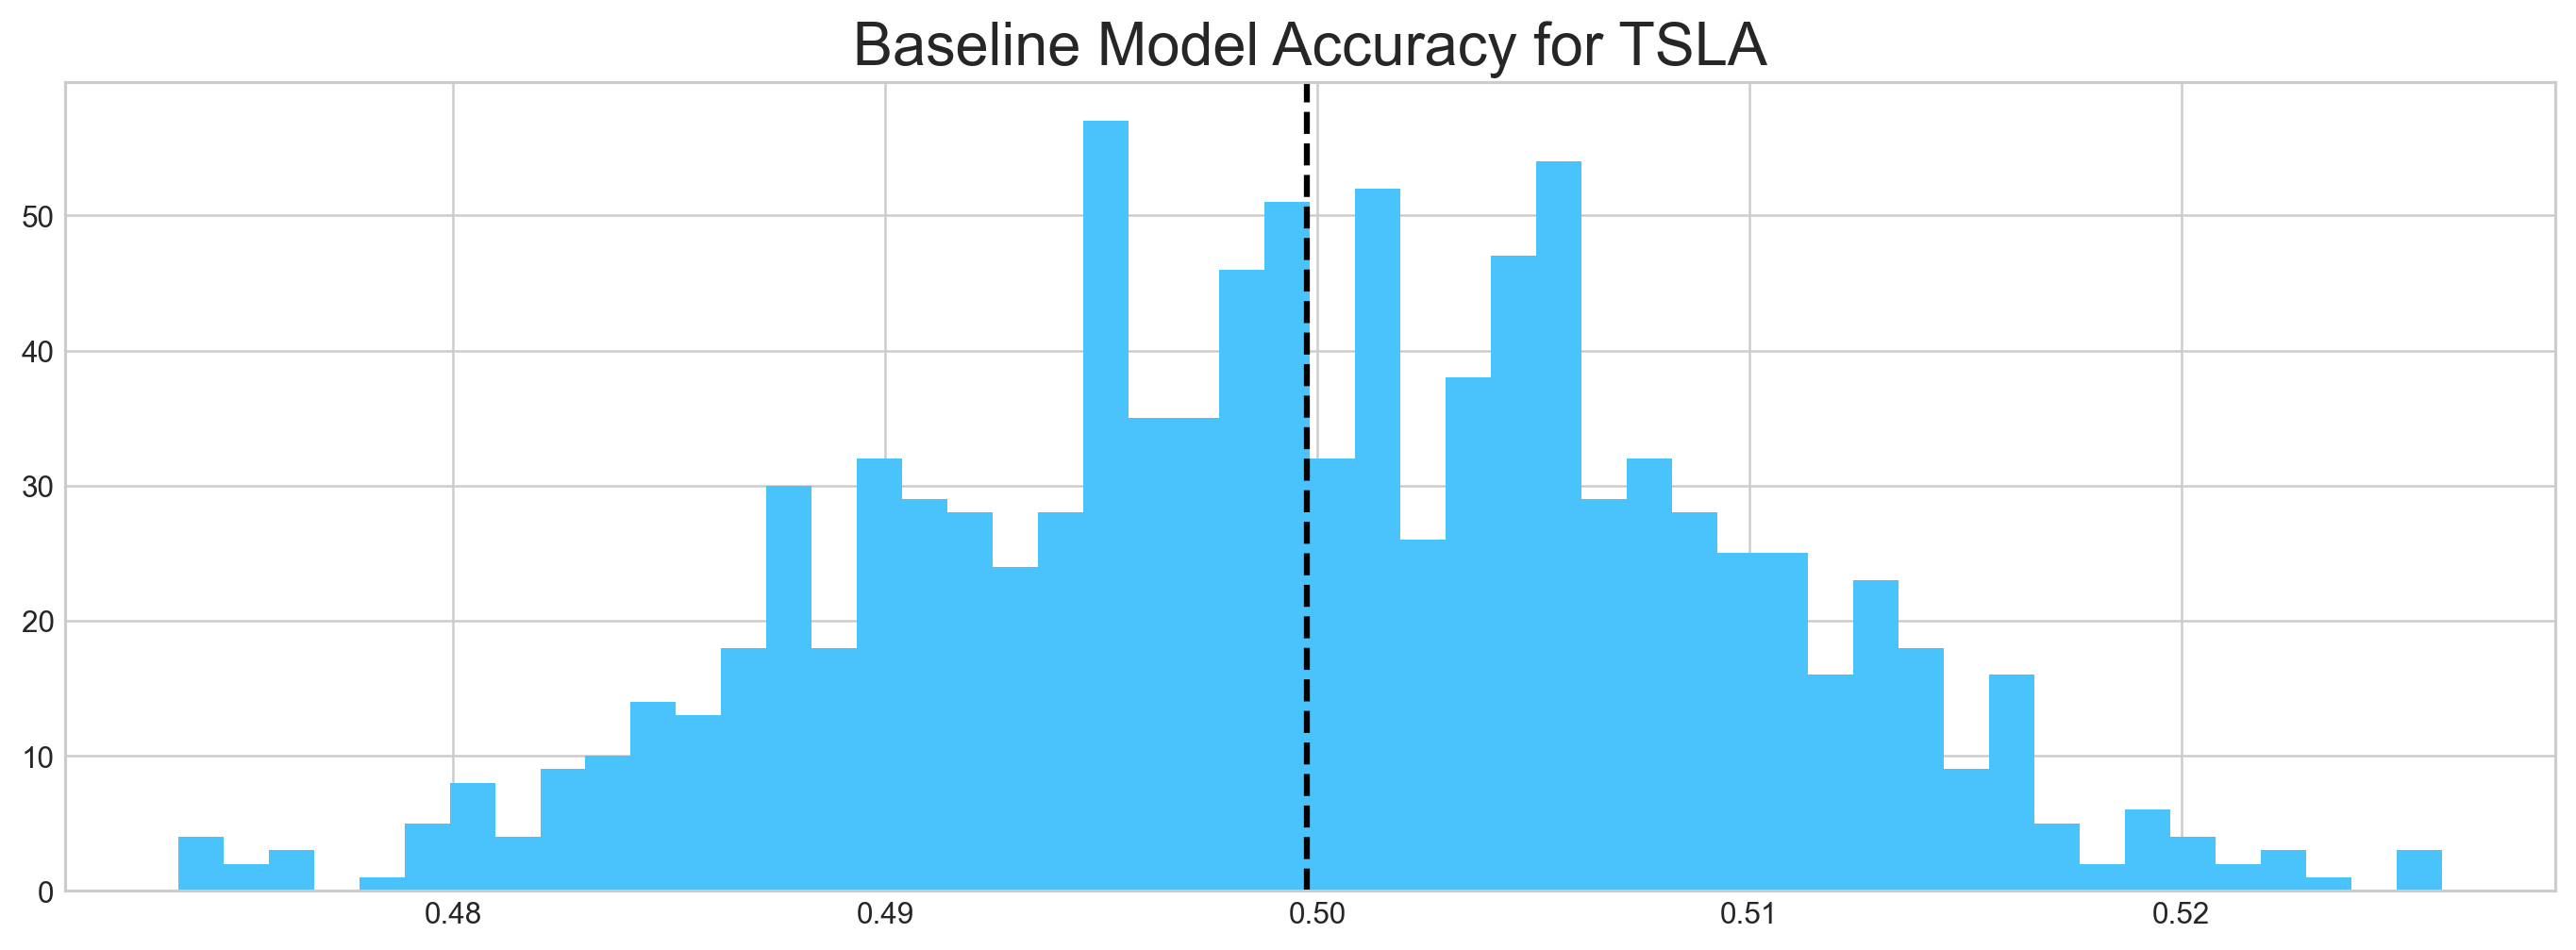

In [91]:
plt.figure(figsize=(15,5))
plt.style.use('seaborn-whitegrid')
plt.hist(baseline_preds, bins=50, facecolor=lightblue)

plt.title(f'Baseline Model Accuracy for {ticker}', fontsize=20)
plt.axvline(np.array(baseline_preds).mean(), c='k', ls='--', lw=2)
plt.show();

---
# ARIMA
#### AutoRegressive Integrated Moving Averate
- `p` = number of lags in the model
- `d` = degree of differencing -> aka number of times raw observations are differenced
- `q` = order of moving average -> moving average window size 
---

### Split Data for Training and Testing 

In [110]:
all_entries = stocks[ticker.lower()].shape[0]
last_252 = all_entries-253
last_600 = all_entries-600
test_600 = last_600-600
train_600 = test_600-600
print(f'{ticker.upper()} historical data contains {all_entries} entries')

TSLA historical data contains 2958 entries


In [112]:
test = list(stocks[ticker.lower()]['Return'][test_600:last_600].values)
train = list(stocks[ticker.lower()]['Return'][train_600:test_600].values)

### Autocorrelation Function
- how time series data points correlate to one another 
- ignore first value -> comparing itself to only itself 

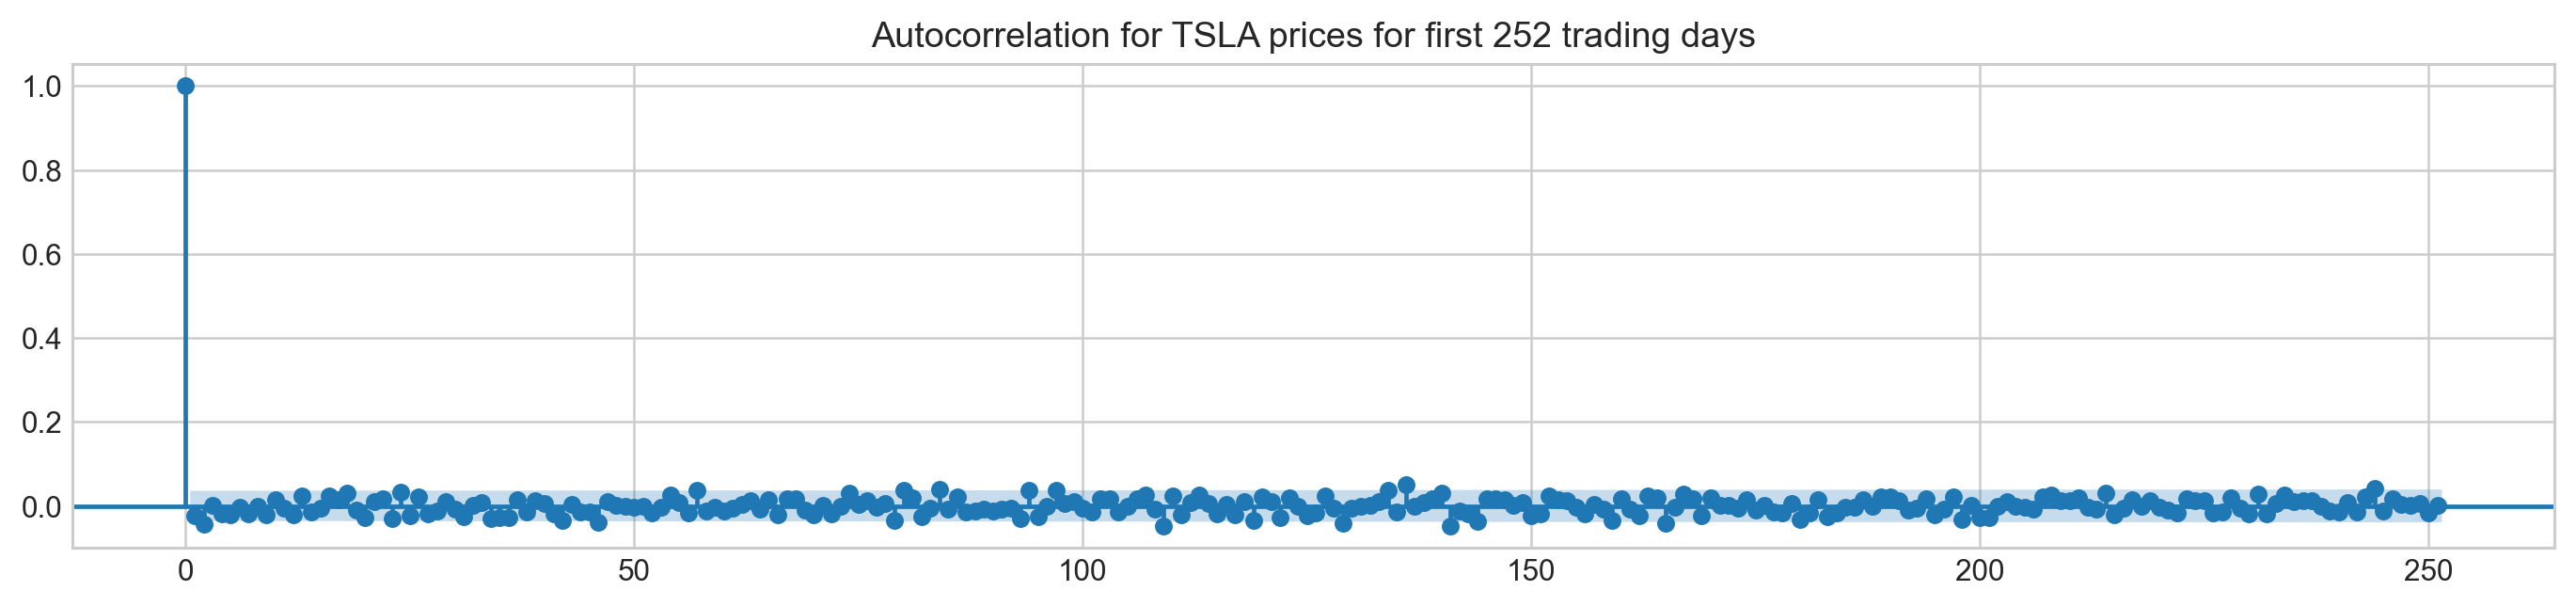

In [106]:
plt.rcParams['figure.figsize'] = (15,3)
plot_acf(stocks[ticker.lower()].Return, lags=range(252))
plt.title(f'Autocorrelation for {ticker.upper()} prices for first 252 trading days')
plt.show()

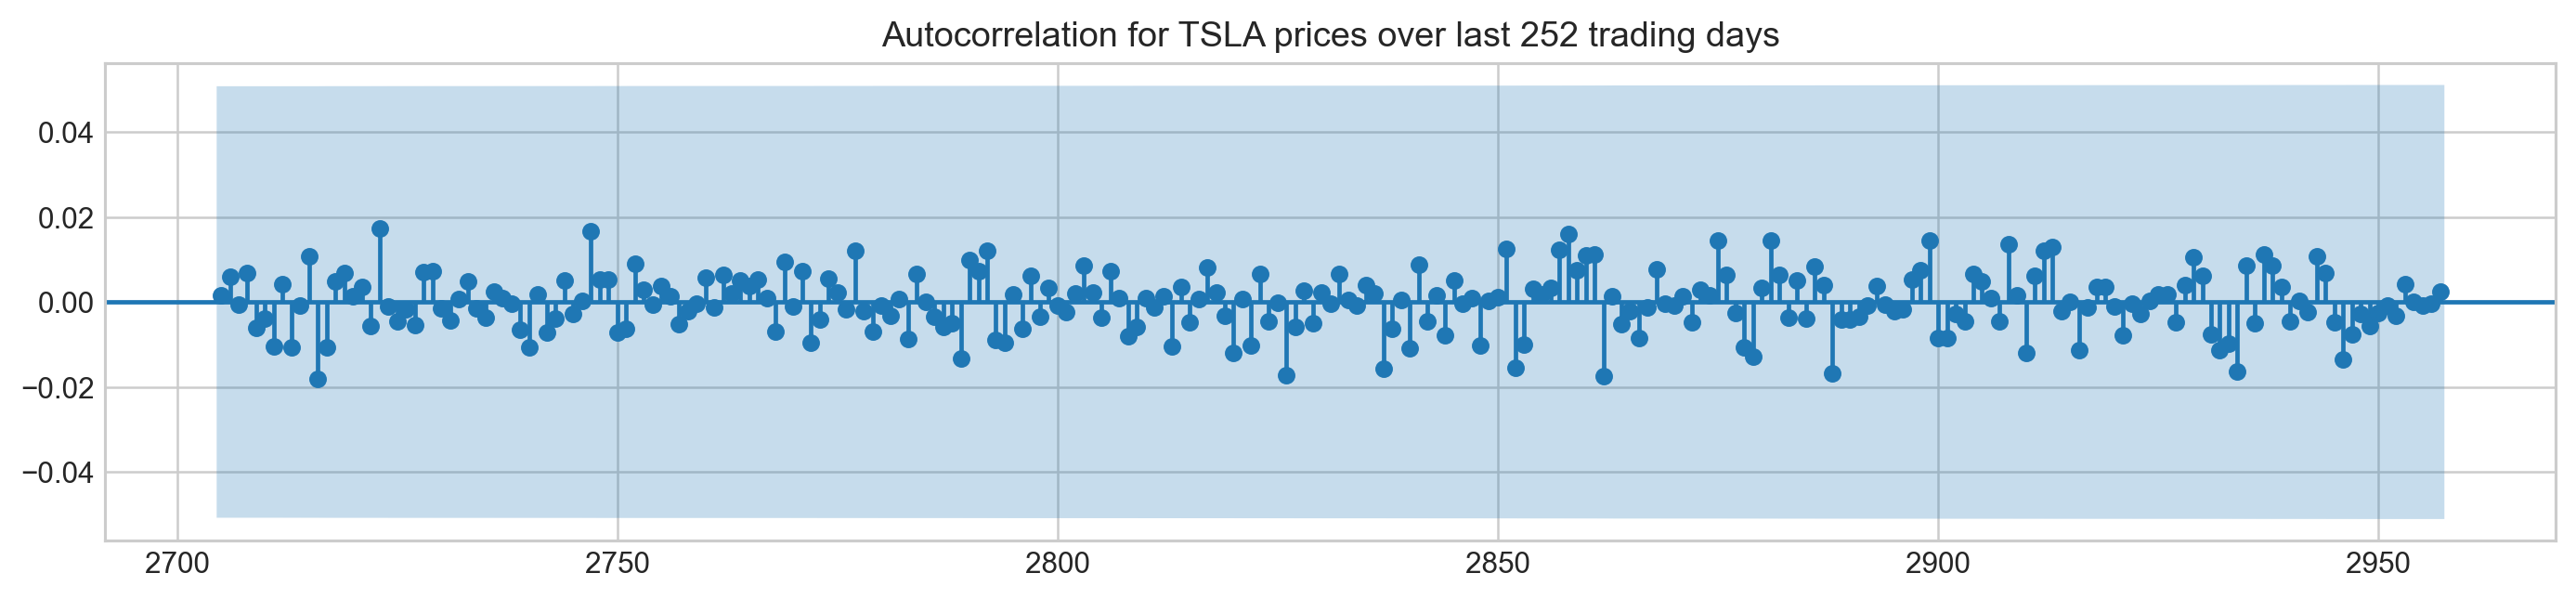

In [107]:
plt.rcParams['figure.figsize'] = (15,3)
plot_acf(stocks[ticker.lower()].Return, lags=range(last_252,all_entries))
plt.title(f'Autocorrelation for {ticker.upper()} prices over last 252 trading days')
plt.show()

#### Reorder Data for New Output

In [109]:
# ARIMA Orders
orders = [(0,0,0), 
          (1,0,0),
          (0,1,0),
          (0,0,1),
          (1,1,0)]

In [117]:
all_predictions = {}

for order in orders:
    try: 
        history = train.copy() #original train set
        order_predictions = []
    
        for i in range(len(test)):
            model = ARIMA(history,order=order) #define model
            model_fit = model.fit(disp=0) #fit model
            y_hat = model_fit.forecast() #prediciting return 
            order_predictions.append(y_hat[0][0]) #first element the prediction 
            history.append(test[i]) #adding following day's 'return' value to the model 
            print(f"{ticker.upper()} prediction: {i+1} of {len(test)}", end='\r')
    
        Binary = lambda data: [1 if x > 0 else 0 for x in data]
        accuracy = accuracy_score(Binary(test),
                                   Binary(order_predictions))
        print('                       ', end='\r')
        print(f"{order} - {round(accuracy,3)*100}%", end='\r')
        all_predictions[order] = order_predictions
    
    except:
        print(f"{order} <== Wrong Order", end='\r')
        pass  

#### Review Predictions on Data

In [133]:
predicted_order = order
print(order)

(1, 1, 0)


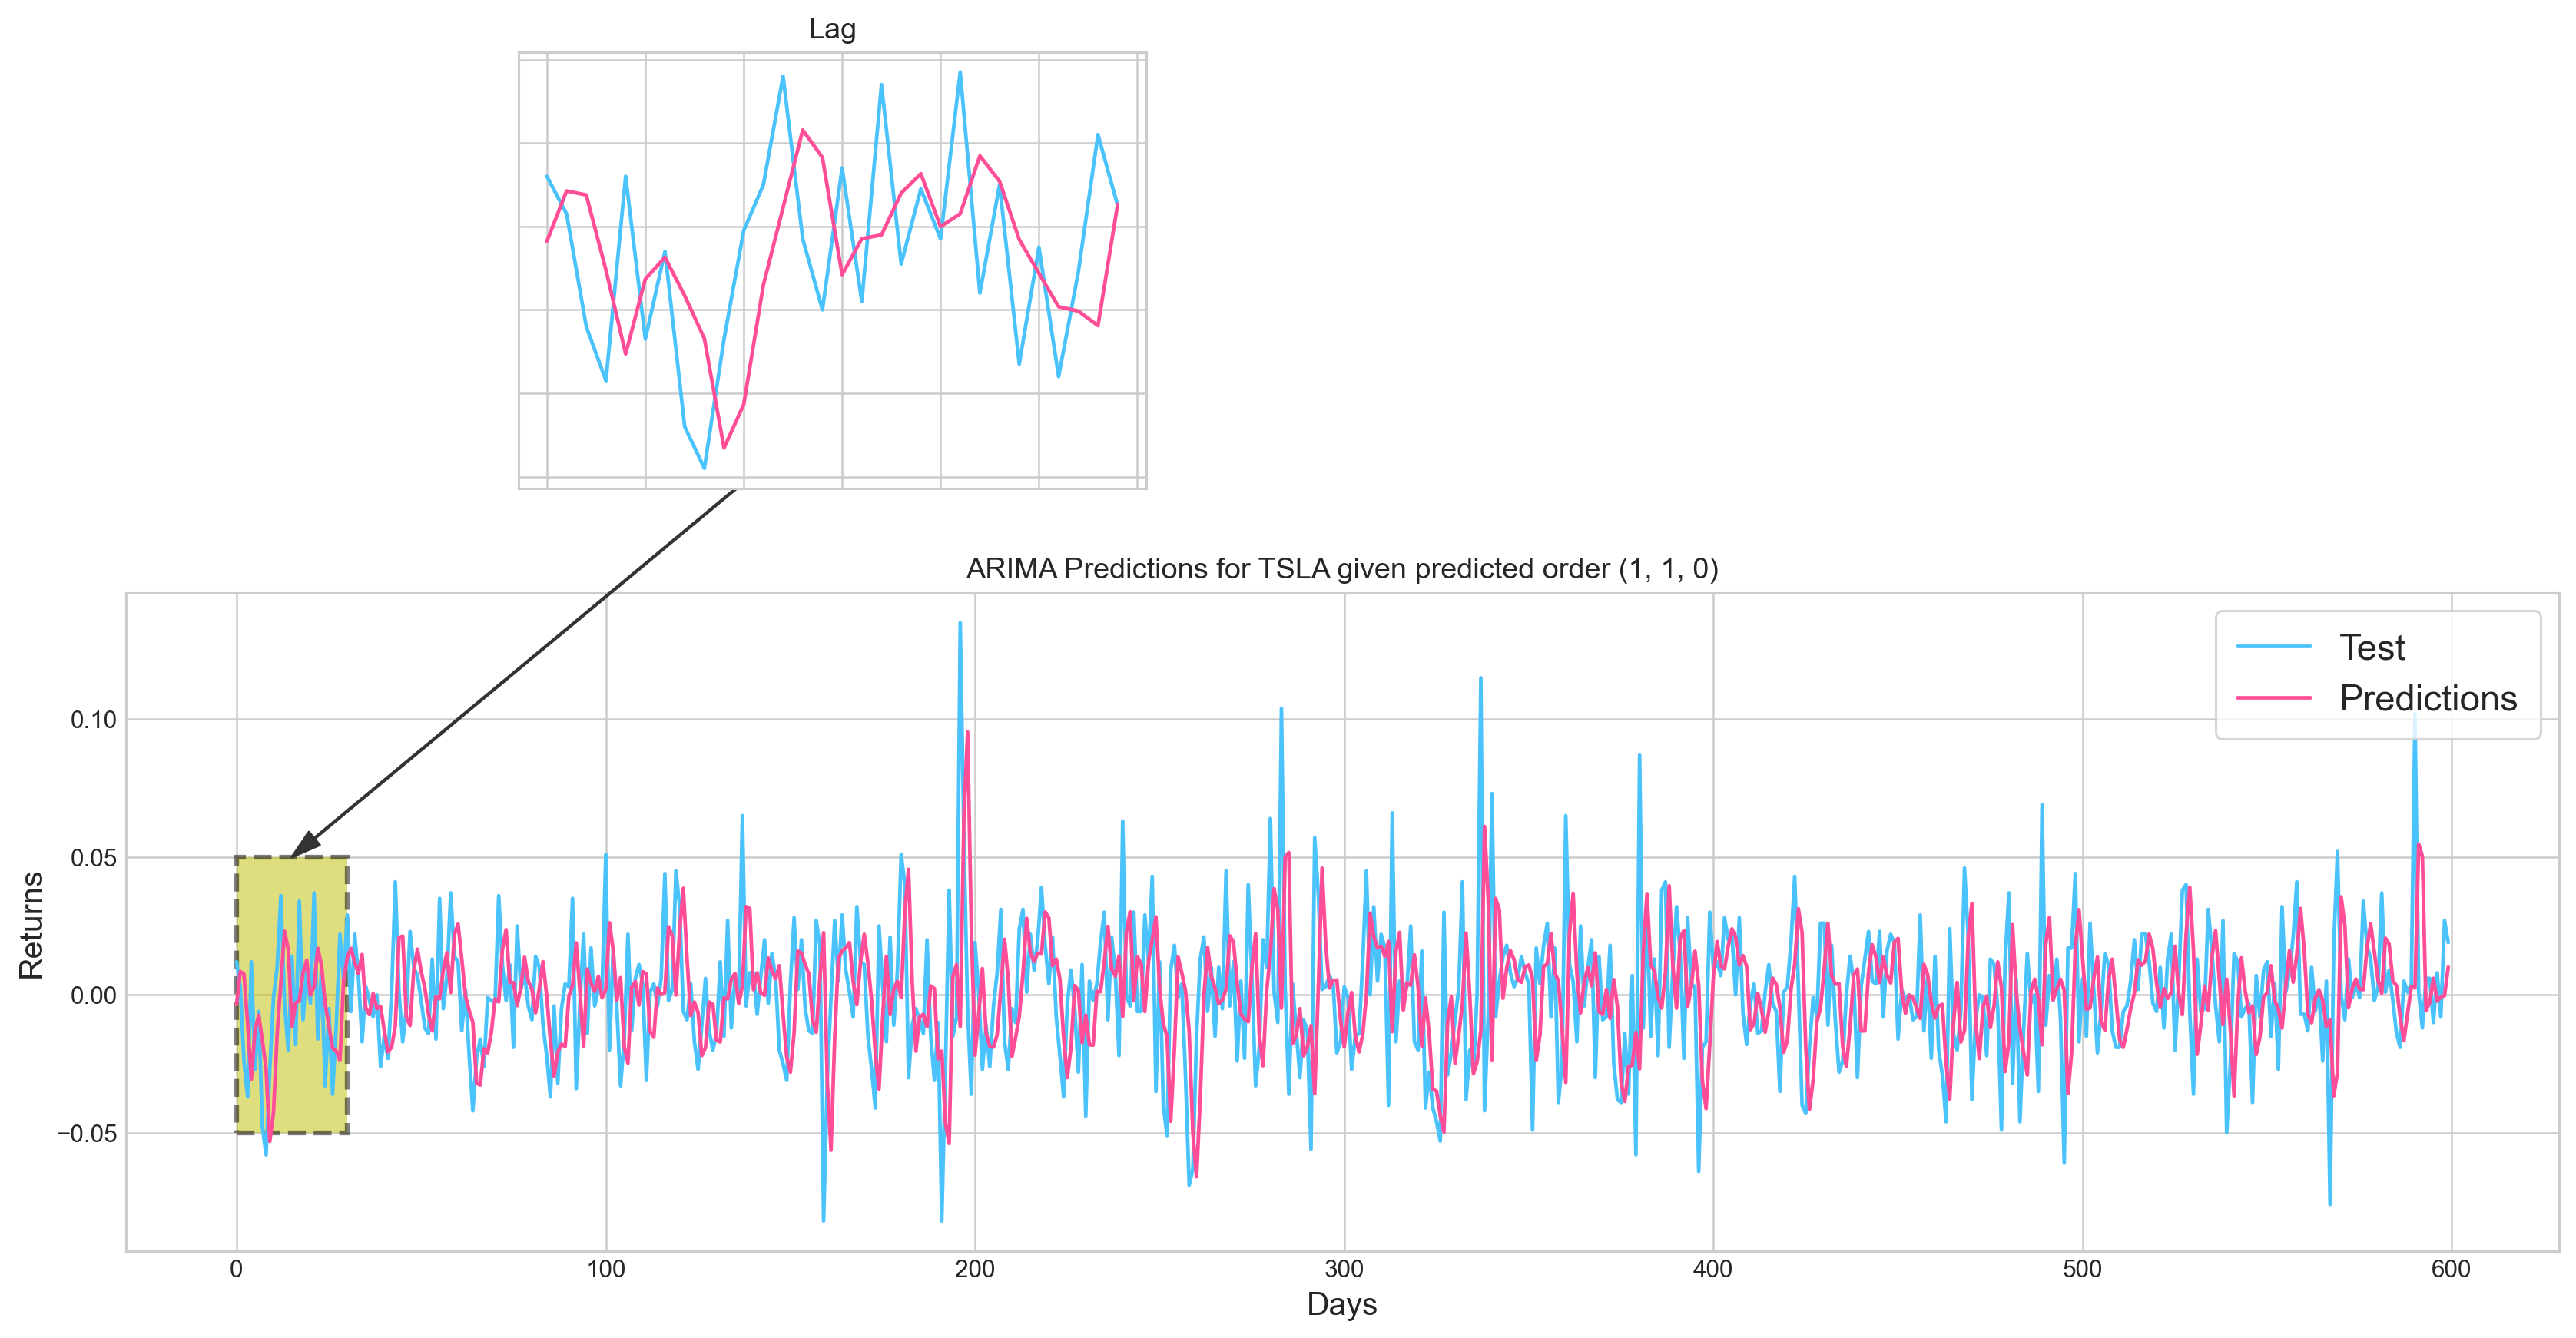

In [132]:
# Main Plot
fig = plt.figure(figsize=(18,5))
plt.plot(test, label='Test', color=lightblue)
plt.plot(all_predictions[predicted_order], label='Predictions', color=pinkyred)

plt.legend(frameon=True, loc=1, ncol=1, fontsize=15, borderpad=.6)
plt.title(f"ARIMA Predictions for {ticker.upper()} given predicted order {predicted_order}")
plt.xlabel('Days',fontsize=13)
plt.ylabel('Returns',fontsize=13)

# Arrow from Subplot to Main Plot
plt.annotate('',
            xy=(15,0.05),
            xytext=(150,.2),
            fontsize=10,
            arrowprops={'width':0.4, 'headwidth':7,'color':black})

# Small Subplot
ax = fig.add_subplot(1,1,1)
rect = patches.Rectangle((0,-.05),30,.1, ls='--', lw=2, facecolor='y', edgecolor='k', alpha=.5)
ax.add_patch(rect)

plt.axes([.25,1,.2,.5])
plt.plot(test[:30], color=lightblue)
plt.plot(all_predictions[predicted_order][:30], color=pinkyred)

plt.tick_params(axis='both', labelbottom=False, labelleft=False)
plt.title('Lag')


plt.show();

#### Histogram 

In [137]:
num_bins = 20

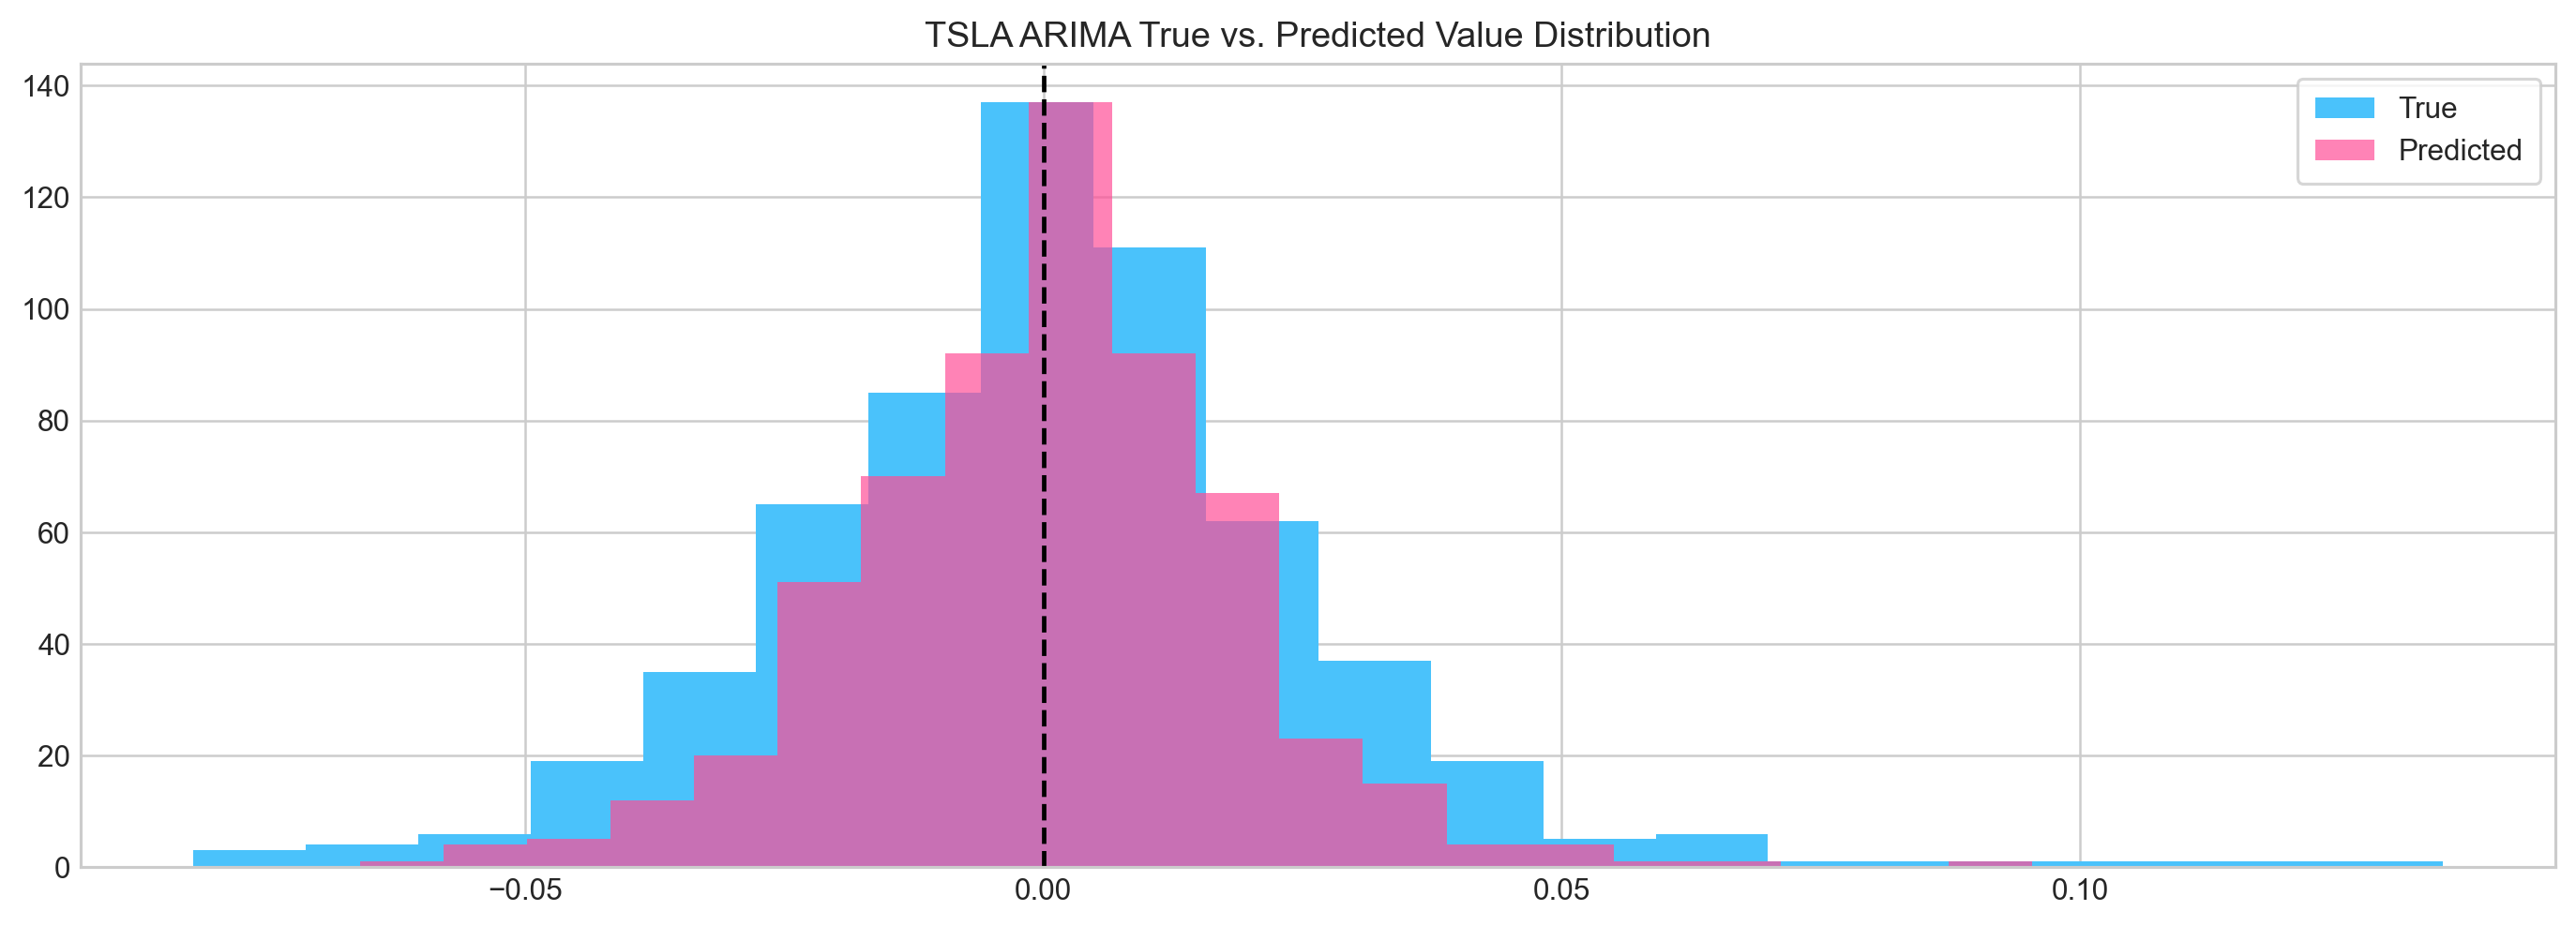

In [138]:
plt.figure(figsize=(15,5))
plt.hist(stocks[ticker.lower()][test_600:last_600].reset_index().Return, 
         bins=num_bins, label='True', facecolor=lightblue)
plt.hist(all_predictions[predicted_order], 
         bins=num_bins, label='Predicted', color=pinkyred, alpha=.7)
plt.axvline(0,c='k',ls='--')

plt.title(f"{ticker.upper()} ARIMA True vs. Predicted Value Distribution")
plt.legend(frameon=True,loc=1, ncol=1,fontsize=10,borderpad=.6)
plt.show()

#### Interpret via Confusion Matrix

In [141]:
Binary = lambda data: [1 if x > 0 else 0 for x in data]

test_binary = Binary(stocks[ticker.lower()][test_600:last_600].reset_index().Return)
train_binary = Binary(all_predictions[predicted_order])

tn, fp, fn, tp = confusion_matrix(test_binary, train_binary).ravel()
accuracy = accuracy_score(test_binary, train_binary)

print(f"True Positive and Negative: {tp + tn}")
print(f"False Positive and Negative: {fp + fn}")
print(f"Accuracy: {round(accuracy*100, 5)}%")

True Positive and Negative: 317
False Positive and Negative: 283
Accuracy: 52.83333%


---
# Sentiment Analysis
- gotta fix your data collection first silly 
---

---
# Features Selection via XGBoost
- extract features for neural networks to improve model accuracy and boost training 
---